# RNA Structure prediction maximizing expected accuracy and stacking

### Import Modules and test files

In [1]:
import sys
import os

# Récupérer le chemin absolu du dossier parent
parent_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))

# Ajouter ce chemin aux modules Python
sys.path.append(parent_dir)
print(parent_dir)

c:\Users\manon\OneDrive\Bureau\X\bioinf_MEA_stacking\MEA_stacking


In [2]:
from modules.nussinov import*
from modules.simple_MEA import *
from modules.MEA_stacking import *

In [3]:
from tests.importdata import *

Folder path: c:\Users\manon\OneDrive\Bureau\X\bioinf_MEA_stacking\MEA_stacking\data


In [4]:
rna_files = import_test_files()

✅ File 5S_rRNA.apsi-54.sci-95.no-1.ref.fa loaded with success (fasta)
✅ File Intron_gpII.apsi-54.sci-66.no-1.ref.fa loaded with success (fasta)
✅ File RF00100.stockholm.txt loaded with success (stockholm)
✅ File RF00568.stockholm.txt loaded with success (stockholm)
✅ File SRP_euk_arch.apsi-34.sci-67.no-1.ref.fa loaded with success (fasta)
✅ File SRP_euk_arch.apsi-68.sci-83.no-1.ref.fa loaded with success (fasta)
✅ File tRNA_15.stk loaded with success (stockholm)
✅ File tRNA_5.aln loaded with success (clustal)
✅ File tRNA_7-clustalw.aln loaded with success (clustal)
✅ File tRNA_7.stk loaded with success (stockholm)


### Choose file to test

In [5]:
test_list_of_sequences=rna_files["tRNA_7-clustalw.aln"]
print(test_list_of_sequences)




['GCGGGGGUGCCCGAGCCUGGCCAAAGGGGUCGGGCUCAGGACCCGAUGGCGUAGGCCUGCGUGGGUUCAAAUCCCACCCCCCGCA', 'GCAGUCGUGGCCGAG--UGGUUAA-GGCGUCUGACUCGAAAUCAGAUUCCCUCUGGGAGCGUAGGUUCGAAUCCUACCGGCUGCG', 'UGGAGUAUAGCCAAG--UGGUAAG--GCAUCGGUUUUUGGUACCG---------GCAUGCAAAGGUUCGAAUCCUUUUACUCCAG', 'CGGAAAGUAGCUUAGCUUGGUAGA--GCACUCGGUUUGGGACCGA---------GGGGUCGCAGGUUCGAAUCCUGUCUUUCCGA', 'GCCGGGGUGGGGUAG--UGGCCAU-CCUGGGGGACUGUGGAUCCC----------CUGACCCGGGUUCAAUUCCCGGUCCCGGCC', '-----GUAAACAUAGUUUAAUCAA-AACAUUAGAUUGUGAAUCUA----------ACAAUAGAGGCUCGAAACCUCUUGCUUACC', '-------------AGUAAAGUCAGCUAAAAAAGCUUUUGGGCCCAUACCCC---AAACAUGUUGGUUAAACCCCUUCCUUUACUA']


### Comparison

In [6]:
pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [7]:
from tests.compare import *

2 0 0
Test 1 (Perfect Match): 1
1 1 0
Test 2 (Missing One Pair): 0.6990252954195317
0 2 0
Test 3 (Extra Compatible Pair): 0
2 0 0
Test 4 (Invalid Pair): 1
0.0


Building consensus structure of : 
['GCGGGGGUGCCCGAGCCUGGCCAAAGGGGUCGGGCUCAGGACCCGAUGGCGUAGGCCUGCGUGGGUUCAAAUCCCACCCCCCGCA', 'GCAGUCGUGGCCGAG--UGGUUAA-GGCGUCUGACUCGAAAUCAGAUUCCCUCUGGGAGCGUAGGUUCGAAUCCUACCGGCUGCG', 'UGGAGUAUAGCCAAG--UGGUAAG--GCAUCGGUUUUUGGUACCG---------GCAUGCAAAGGUUCGAAUCCUUUUACUCCAG', 'CGGAAAGUAGCUUAGCUUGGUAGA--GCACUCGGUUUGGGACCGA---------GGGGUCGCAGGUUCGAAUCCUGUCUUUCCGA', 'GCCGGGGUGGGGUAG--UGGCCAU-CCUGGGGGACUGUGGAUCCC----------CUGACCCGGGUUCAAUUCCCGGUCCCGGCC', '-----GUAAACAUAGUUUAAUCAA-AACAUUAGAUUGUGAAUCUA----------ACAAUAGAGGCUCGAAACCUCUUGCUUACC', '-------------AGUAAAGUCAGCUAAAAAAGCUUUUGGGCCCAUACCCC---AAACAUGUUGGUUAAACCCCUUCCUUUACUA']
Using the MEA_stacking with parameter gamma =1, delta=2
...
['(((((((..((.((((((((((.....)))))))))).)).......(((....)))...(((((.......)))))))))))).', '((((((((((((......))))).....((((((.......))))))((((...))))..(((((.......)))))))))))).', '(((((((..((((....)))).....((((((((.......))))...........))))(((((.......)))))))))))).', '(((((((...((

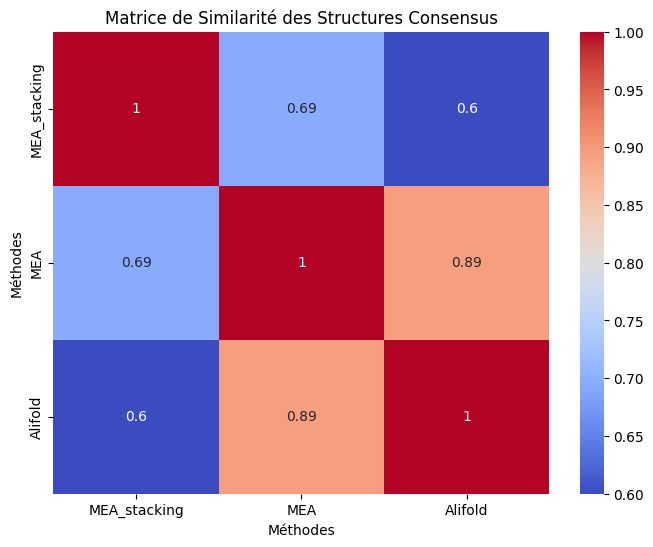

In [8]:

structures, sim_matrix = similarity_matrix(test_list_of_sequences,levenshtein_distance,1,2,2)
plot_similarity_matrix(sim_matrix, method_names)

### Visualisation

In [9]:
import tempfile
from IPython.display import SVG

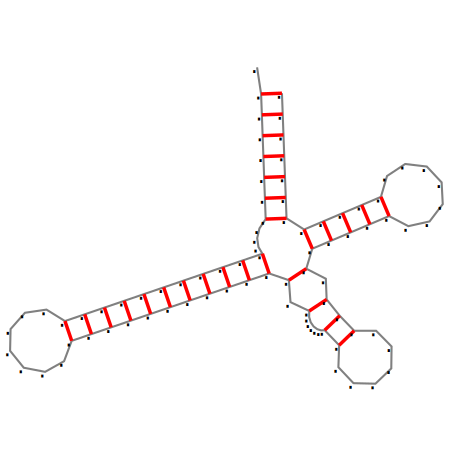

In [10]:
ss=structures[0]

sequence="".join(["." for i in range(len(ss))])

fp = tempfile.NamedTemporaryFile(suffix=".svg", delete=False)
RNA.svg_rna_plot(sequence, structure=ss, ssfile=fp.name)
SVG(fp.name)

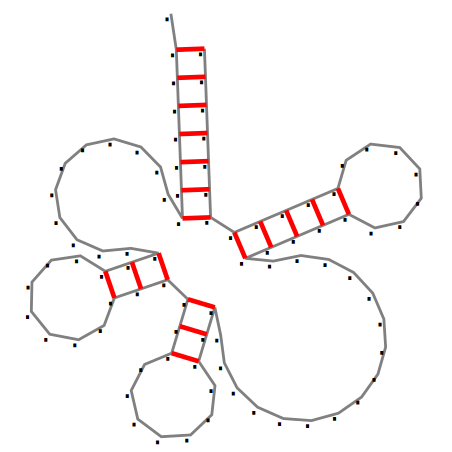

In [11]:
ss=structures[1]

sequence="".join(["." for i in range(len(ss))])

fp = tempfile.NamedTemporaryFile(suffix=".svg", delete=False)
RNA.svg_rna_plot(sequence, structure=ss, ssfile=fp.name)
SVG(fp.name)

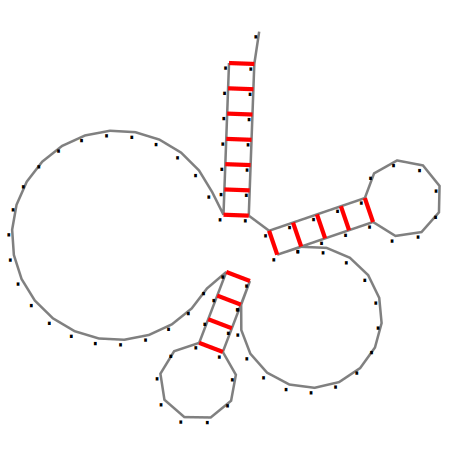

In [12]:
ss=structures[2]

sequence="".join(["." for i in range(len(ss))])

fp = tempfile.NamedTemporaryFile(suffix=".svg", delete=False)
RNA.svg_rna_plot(sequence, structure=ss, ssfile=fp.name)
SVG(fp.name)

### Test with different parameters

We first used Levenshtein distance to find optimised values of gamma and delta.

In [13]:
import matplotlib.pyplot as plt

ss0 = alifold_alignment(test_list_of_sequences, 2)

gamma=0.02
#delta = 0.6
scores = []  # Liste pour stocker les scores
i_values = list(range(1, 50))  # Liste des valeurs de i testées

i_max = 0
score_max = 0

for i in i_values:
    ss1 = MEA_stacking(test_list_of_sequences, gamma, 2/i, m=2)
    score = levenshtein_distance(ss0, ss1)
    scores.append(score)  # Stocker le score

    if score > score_max:
        score_max = score
        i_max = i

# 📊 Affichage du graphe
plt.figure(figsize=(8, 5))
plt.plot(i_values, scores, marker='o', linestyle='-', color='b', label="Score Levenshtein")
plt.axvline(i_max, color='r', linestyle='--', label=f"Max score at i={i_max}")
plt.xlabel("Valeur de i")
plt.ylabel("Score de Levenshtein")
plt.title("Évolution du score en fonction de i")
plt.legend()
plt.grid(True)
plt.show()

print(f"Meilleure valeur de i : {2/i} avec un score de {score_max}")


Building consensus structure of : 
['GCGGGGGUGCCCGAGCCUGGCCAAAGGGGUCGGGCUCAGGACCCGAUGGCGUAGGCCUGCGUGGGUUCAAAUCCCACCCCCCGCA', 'GCAGUCGUGGCCGAG--UGGUUAA-GGCGUCUGACUCGAAAUCAGAUUCCCUCUGGGAGCGUAGGUUCGAAUCCUACCGGCUGCG', 'UGGAGUAUAGCCAAG--UGGUAAG--GCAUCGGUUUUUGGUACCG---------GCAUGCAAAGGUUCGAAUCCUUUUACUCCAG', 'CGGAAAGUAGCUUAGCUUGGUAGA--GCACUCGGUUUGGGACCGA---------GGGGUCGCAGGUUCGAAUCCUGUCUUUCCGA', 'GCCGGGGUGGGGUAG--UGGCCAU-CCUGGGGGACUGUGGAUCCC----------CUGACCCGGGUUCAAUUCCCGGUCCCGGCC', '-----GUAAACAUAGUUUAAUCAA-AACAUUAGAUUGUGAAUCUA----------ACAAUAGAGGCUCGAAACCUCUUGCUUACC', '-------------AGUAAAGUCAGCUAAAAAAGCUUUUGGGCCCAUACCCC---AAACAUGUUGGUUAAACCCCUUCCUUUACUA']
Using RNA Alifold
GCGGGGGUGCCCGAGCCUGGCCAAAGGGGUCGGGCUCAGGACCCGAUGGCGUAGGCCUGCGUGGGUUCAAAUCCCACCCCCCGCA
GCAGUCGUGGCCGAG--UGGUUAA-GGCGUCUGACUCGAAAUCAGAUUCCCUCUGGGAGCGUAGGUUCGAAUCCUACCGGCUGCG
UGGAGUAUAGCCAAG--UGGUAAG--GCAUCGGUUUUUGGUACCG---------GCAUGCAAAGGUUCGAAUCCUUUUACUCCAG
CGGAAAGUAGCUUAGCUUGGUAGA--GCACUCGGUUUGGGACCGA---------GGGGUCGCAGG

KeyboardInterrupt: 

We then used MCC to optimize gamma and delta.

Building consensus structure of : 
['GGAGGAUUAGCUCAGCUGGGAGAGCAUCUGCCUUACAAGCAGAGGG-----------UCGGCGGUUCGAGCCCGUCAUCCUCC', 'GCCUUCCUAGCUCAG-UGGUAGAGCGCACGGCUUUUAACCGUGUGG-----------UCGUGGGUUCGAUCCCCACGGAAGGC', 'GCCUUUAUAGCUUAG-UGGUAAAGCGAUAAACUGAAGAUUUAUUUA-----------CAUGUAGUUCGAUUCUCAUUAAGGGC', 'GCGGAUAUAACUUAGGGGUUAAAGUUGCAGAUUGUGGCUCUGAAAA------------CACGGGUUCGAAUCCCGUUAUUCGC', 'GGAAAAUU-GAUCAUCGGCAAGAUAAGUUAUUUACUAAAUAAUAGGAUUUAAUAACCUGGUGAGUUCGAAUCUCACAUUUUCC']
Using RNA Alifold
GGAGGAUUAGCUCAGCUGGGAGAGCAUCUGCCUUACAAGCAGAGGG-----------UCGGCGGUUCGAGCCCGUCAUCCUCC
GCCUUCCUAGCUCAG-UGGUAGAGCGCACGGCUUUUAACCGUGUGG-----------UCGUGGGUUCGAUCCCCACGGAAGGC
GCCUUUAUAGCUUAG-UGGUAAAGCGAUAAACUGAAGAUUUAUUUA-----------CAUGUAGUUCGAUUCUCAUUAAGGGC
GCGGAUAUAACUUAGGGGUUAAAGUUGCAGAUUGUGGCUCUGAAAA------------CACGGGUUCGAAUCCCGUUAUUCGC
GGAAAAUU-GAUCAUCGGCAAGAUAAGUUAUUUACUAAAUAAUAGGAUUUAAUAACCUGGUGAGUUCGAAUCUCACAUUUUCC
(((((((..((((........))))((((((.......))))))...............(((((.......)))))))))))) [ -25.3

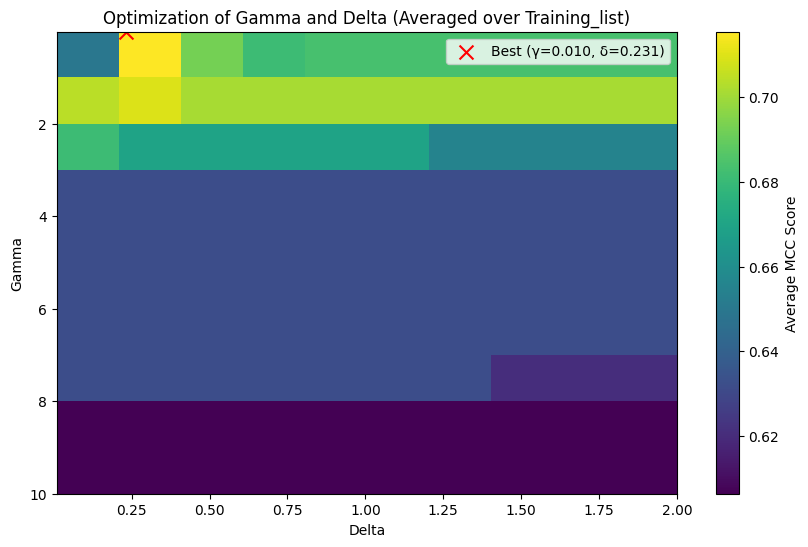

Best parameters: gamma=0.01, delta=0.23111111111111113 with avg MCC score = 0.7155


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import matthews_corrcoef

Training_list=["tRNA_5.aln",
               "tRNA_7-clustalw.aln",
               "tRNA_7.stk",
               "tRNA_15.stk"]

# Define gamma and delta search ranges
gamma_values = np.linspace(0.01, 10, 10)  # Range of gamma values
delta_values = np.linspace(0.01, 2, 10)  # Range of delta values

# Store best parameters
best_gamma = None
best_delta = None
best_score = -np.inf  # Initialize for maximization

# Score matrix for visualization
score_matrix = np.zeros((len(gamma_values), len(delta_values)))

alifold_list=[]
for file_test_list_of_sequences in Training_list:
    ss0 = alifold_alignment(rna_files[file_test_list_of_sequences], 2)
    alifold_list.append(ss0)

# Grid search over gamma and delta
for g_idx, gamma in enumerate(gamma_values):
    for d_idx, delta in enumerate(delta_values):
        total_score = 0
        count = 0

        # Compute average MCC over all test sets
        for i in range (len(Training_list)):
            ss0 = alifold_list[i]  # Reference structure
            ss1 = MEA_stacking(rna_files[file_test_list_of_sequences][:3], gamma, delta, m=2)  # Predicted structure
            
            score = levenshtein_distance(ss0, ss1)  # Compute MCC score
            
            total_score += score
            count += 1

        avg_score = total_score / count  # Compute mean MCC score
        score_matrix[g_idx, d_idx] = avg_score  # Store in matrix

        # Update best parameters if new max score is found
        if avg_score > best_score:
            best_score = avg_score
            best_gamma = gamma
            best_delta = delta

# Heatmap visualization
plt.figure(figsize=(10, 6))
plt.imshow(score_matrix, aspect='auto', cmap='viridis', extent=[min(delta_values), max(delta_values), max(gamma_values), min(gamma_values)])
plt.colorbar(label="Average Levenshtein Score")
plt.xlabel("Delta")
plt.ylabel("Gamma")
plt.title("Optimization of Gamma and Delta (Averaged over Training_list)")
plt.scatter(best_delta, best_gamma, color='red', marker='x', s=100, label=f"Best (γ={best_gamma:.3f}, δ={best_delta:.3f})")
plt.legend()
plt.show()

print(f"Best parameters: gamma={best_gamma}, delta={best_delta} with avg MCC score = {best_score:.4f}")


In [14]:
best_gamma=1.12
best_delta=0.01

### Evaluation

We used Mathew's correlation coefficient to compare MEA stacking's performance to Alifold's: Base pairs that are not part of the reference structure are counted as false positives only if they are inconsistent with the reference structure, while they are ignored if they can be added to the reference structure.

In this part we test our "optimized" parameters against our test data.

Building consensus structure of : 
['AGCGGGGU-AGAGGAAUUGGUCGACUCAUCAGGCUCAUGACCUGAAGAC-UGCAG----------GUUCGAAUCC-UGUCCCCGCCU', 'UGCAAUAU-GAUGUAAUUGGUUAACAUUUUAGGGUCAUGACCUAAUUA--UAUAC----------GUUCAAAUCG-UAUUAUUGCUA', 'GCGGAUGU-GGCGGAAUUGGCAGACGCGCUAGAAUCAGGCUCUAGUGUC-UUUACAGACGUGGGGGUUCAAGUCC-CUUCAUCCGCA', 'GCCGGGGU-GGGGU-AGUGGCCAUCCUGGGGGACUGUGGAUCCCCUGAC-CC-----------GGGUUCAAUUCC-CGGUCCCGGCC', 'UGGGAAUU-AGCCAAG-UUGGUAAGGCAUAGCACUUUGACUGCUAGAUG-CAAA----------GGUUCGAGUCC-UUUAUUCCCAG', 'AGGAGAUU-AGCUUAA-UUGGUAUAGCAUUCGUUUUACACACGAAAGAU-UAUA----------GGUUCGA--CC-UAUAUUUCCUA', 'GGGCCGGU-AGCUCAGCCUGGGAGAGCGUCGGCUUUGCAAGCCGAAGGC-CCCG----------GGUUCGAAUCC-CGGCCGGUCCA', 'GGGGAAUU-AGCUCAG-CUGGGAGAGCGCCUGCUUUGCACGCAGGAGGU-CAGC----------GGUUCGAUCCC-GCUAUUCUCCA', 'GCUCCAGU-GGCCUAA-UGGAUAUGGCUUUGGACUUCUAAUCCAAAGGU-UGCG----------GGUUCGAGUCC-CGUCUGGAGUA', 'GCAUCCGU-AGCUCAGCUGGAUAGAGUACUCGGCUACGAACCGAGCGGU-CGGA----------GGUUCGAAUCC-UCCCGGAUGCA', 'GUCUCUGU-GGCGCAAUCGGUUAGCGCGUUCGGCUGUUAACCGAAAGAU-UGG

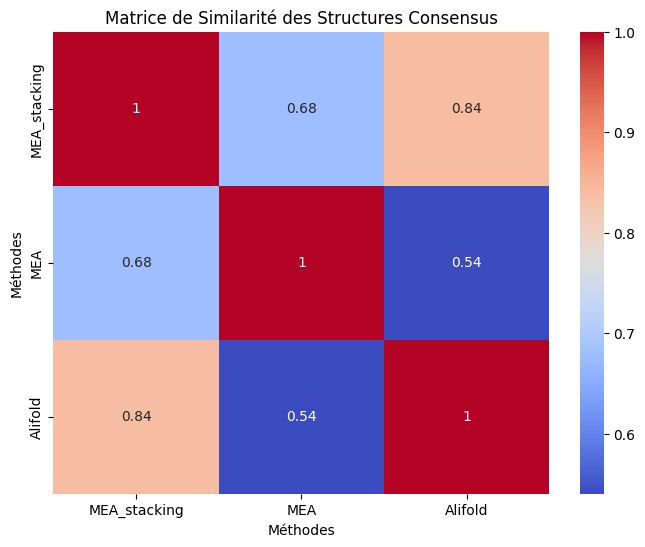

Building consensus structure of : 
['GGAGGAUUAGCUCAGCUGGGAGAGCAUCUGCCUUACAAGCAGAGGG-----------UCGGCGGUUCGAGCCCGUCAUCCUCC', 'GCCUUCCUAGCUCAG-UGGUAGAGCGCACGGCUUUUAACCGUGUGG-----------UCGUGGGUUCGAUCCCCACGGAAGGC', 'GCCUUUAUAGCUUAG-UGGUAAAGCGAUAAACUGAAGAUUUAUUUA-----------CAUGUAGUUCGAUUCUCAUUAAGGGC', 'GCGGAUAUAACUUAGGGGUUAAAGUUGCAGAUUGUGGCUCUGAAAA------------CACGGGUUCGAAUCCCGUUAUUCGC', 'GGAAAAUU-GAUCAUCGGCAAGAUAAGUUAUUUACUAAAUAAUAGGAUUUAAUAACCUGGUGAGUUCGAAUCUCACAUUUUCC']
Using the MEA_stacking with parameter gamma =0.01, delta=0.23111111111111113
...
['(((((((..((((........)))).(((((.......)))))................(((((.......))))))))))))', '(((((((..((((........))))((((((.......))))))...............(((((.......))))))))))))', '(((((((..((((........))))((((((.......))))))..............(((.((.......))))))))))))', '((((((((((((....))))).(((((((...)))))))....................(((((.......))))))))))))', '(((((((......(((.....)))..(((((((...)))))))(((.........))).(((((.......))))))))))))']
Building con

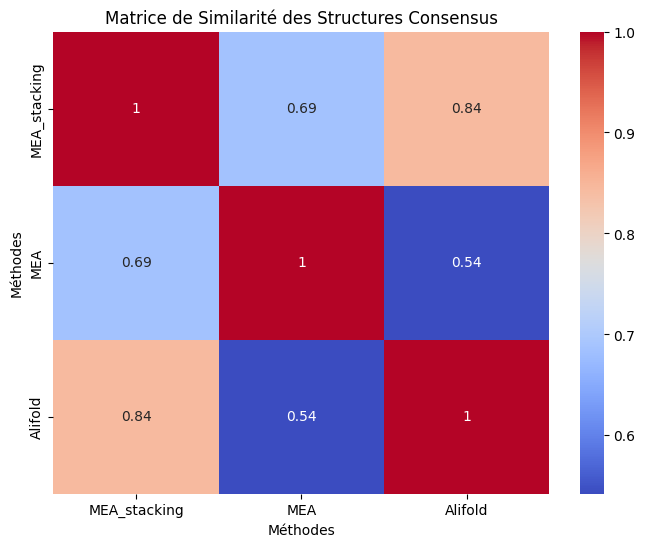

Building consensus structure of : 
['GCGGGGGUGCCCGAGCCUGGCCAAAGGGGUCGGGCUCAGGACCCGAUGGCGUAGGCCUGCGUGGGUUCAAAUCCCACCCCCCGCA', 'GCAGUCGUGGCCGAG--UGGUUAA-GGCGUCUGACUCGAAAUCAGAUUCCCUCUGGGAGCGUAGGUUCGAAUCCUACCGGCUGCG', 'UGGAGUAUAGCCAAG--UGGUAAG--GCAUCGGUUUUUGGUACCG---------GCAUGCAAAGGUUCGAAUCCUUUUACUCCAG', 'CGGAAAGUAGCUUAGCUUGGUAGA--GCACUCGGUUUGGGACCGA---------GGGGUCGCAGGUUCGAAUCCUGUCUUUCCGA', 'GCCGGGGUGGGGUAG--UGGCCAU-CCUGGGGGACUGUGGAUCCC----------CUGACCCGGGUUCAAUUCCCGGUCCCGGCC', '-----GUAAACAUAGUUUAAUCAA-AACAUUAGAUUGUGAAUCUA----------ACAAUAGAGGCUCGAAACCUCUUGCUUACC', '-------------AGUAAAGUCAGCUAAAAAAGCUUUUGGGCCCAUACCCC---AAACAUGUUGGUUAAACCCCUUCCUUUACUA']
Using the MEA_stacking with parameter gamma =0.01, delta=0.23111111111111113
...
['(((((((..((.((((((((((.....)))))))))).)).......(((....)))...(((((.......)))))))))))).', '((((((((((((......))))).....((((((.......))))))((((...))))..(((((.......)))))))))))).', '(((((((..((((....)))).....((((((((.......))))...........))))(((((.......))))))))

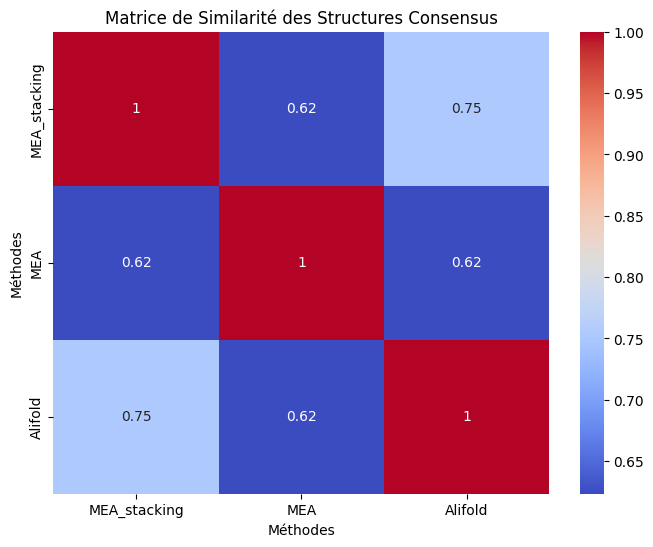

Building consensus structure of : 
['GCAGUCGUGGCCGAGU---GGUUAAGGCGUCUGACUCGAAAUCAGAUUCCCUCUGGGAGCGUAGGUUCGAAUCCUACCGGCUGCG', 'GCGGGGGUGCCCGAGCCUGGCCAAAGGGGUCGGGCUCAGGACCCGAUGGCGUAGGCCUGCGUGGGUUCAAAUCCCACCCCCCGCA', 'UGGAGUAUAGCCAAG--UGG--UAAGGCAUCGGUUUUUGGUACCG---------GCAUGCAAAGGUUCGAAUCCUUUUACUCCAG', 'CGGAAAGUAGCUUAGCUUGG--UAGAGCACUCGGUUUGGGACCGA---------GGGGUCGCAGGUUCGAAUCCUGUCUUUCCGA', 'GCCGGGGUGGGGUAGUGGCCAUCCUGG---GGGACUGUGGAUCCC----------CUGACCCGGGUUCAAUUCCCGGUCCCGGCC', 'GUAAACAUAGUUUA------AUCAAAACAUUAGAUUGUGAAUCUAA----------CAAUAGAGGCUCGAAACCUCUUGCUUACC', 'AGUAAAGUCAGCUA------AAAAAGCUUUUGGGCCCAUACCCCAA----------ACAUGUUGGUUAAACCCCUUCCUUUACUA']
Using the MEA_stacking with parameter gamma =0.01, delta=0.23111111111111113
...
['(((((((..(((.............)))((((((.......))))))((((...))))..(((((.......)))))))))))).', '(((((((..((.((((((((((.....)))))))))).)).......(((....)))...(((((.......)))))))))))).', '(((((((...(((....)))......((((((((.......))))...........))))(((((.......))))))))

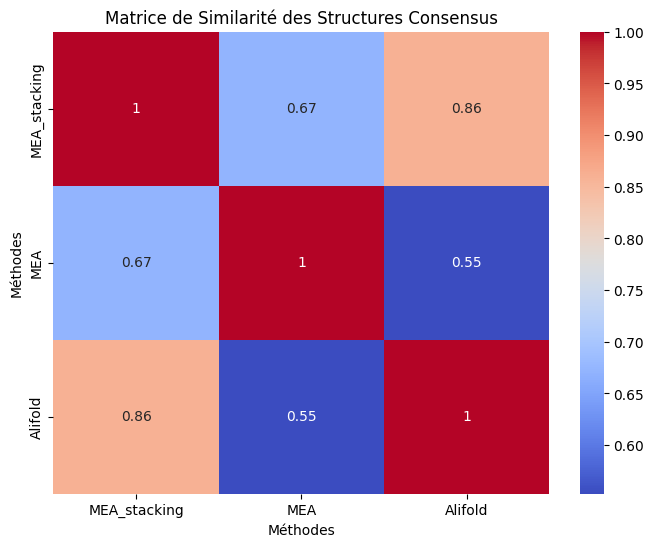

In [20]:
#test data

TEST_DATA=[rna_files["tRNA_15.stk"],rna_files["tRNA_5.aln"],rna_files["tRNA_7-clustalw.aln"],rna_files["tRNA_7.stk"]]

# MCC similarity matrices
for list_of_sequences in TEST_DATA:
    structures, sim_matrix = similarity_matrix(list_of_sequences,levenshtein_distance,best_gamma,best_delta,2)
    plot_similarity_matrix(sim_matrix, method_names)

### Specificity, sensitivity, PPV, F-score

In [16]:
for list_of_sequences in TEST_DATA:
    reference_structure = alifold_alignment(list_of_sequences,2)
    predicted_structure = MEA_stacking(list_of_sequences, 1, 1, m=2)
    sens, spec, ppv, f1 = evaluate_structure(reference_structure, predicted_structure)
    print(f"Sensitivity: {sens:.3f}, Specificity: {spec:.3f}, PPV: {ppv:.3f}, F1-score: {f1:.3f}")


Building consensus structure of : 
['AGCGGGGU-AGAGGAAUUGGUCGACUCAUCAGGCUCAUGACCUGAAGAC-UGCAG----------GUUCGAAUCC-UGUCCCCGCCU', 'UGCAAUAU-GAUGUAAUUGGUUAACAUUUUAGGGUCAUGACCUAAUUA--UAUAC----------GUUCAAAUCG-UAUUAUUGCUA', 'GCGGAUGU-GGCGGAAUUGGCAGACGCGCUAGAAUCAGGCUCUAGUGUC-UUUACAGACGUGGGGGUUCAAGUCC-CUUCAUCCGCA', 'GCCGGGGU-GGGGU-AGUGGCCAUCCUGGGGGACUGUGGAUCCCCUGAC-CC-----------GGGUUCAAUUCC-CGGUCCCGGCC', 'UGGGAAUU-AGCCAAG-UUGGUAAGGCAUAGCACUUUGACUGCUAGAUG-CAAA----------GGUUCGAGUCC-UUUAUUCCCAG', 'AGGAGAUU-AGCUUAA-UUGGUAUAGCAUUCGUUUUACACACGAAAGAU-UAUA----------GGUUCGA--CC-UAUAUUUCCUA', 'GGGCCGGU-AGCUCAGCCUGGGAGAGCGUCGGCUUUGCAAGCCGAAGGC-CCCG----------GGUUCGAAUCC-CGGCCGGUCCA', 'GGGGAAUU-AGCUCAG-CUGGGAGAGCGCCUGCUUUGCACGCAGGAGGU-CAGC----------GGUUCGAUCCC-GCUAUUCUCCA', 'GCUCCAGU-GGCCUAA-UGGAUAUGGCUUUGGACUUCUAAUCCAAAGGU-UGCG----------GGUUCGAGUCC-CGUCUGGAGUA', 'GCAUCCGU-AGCUCAGCUGGAUAGAGUACUCGGCUACGAACCGAGCGGU-CGGA----------GGUUCGAAUCC-UCCCGGAUGCA', 'GUCUCUGU-GGCGCAAUCGGUUAGCGCGUUCGGCUGUUAACCGAAAGAU-UGG

In [17]:
# Example structures in dot-bracket notation
ref_structure = "..((..)).."  # Reference: Base pairs (2,7) and (3,6)
pred_structure1 = "..((..)).."  # Perfect match (should give MCC = 1)
pred_structure2 = "..(....).."  # Missing one base pair (should lower MCC)
pred_structure3 = "..((...))."  # Extra compatible base pair (should not decrease MCC)
pred_structure4 = "..((..)).("  # Invalid closing (should decrease MCC)

# Run tests
print("Test 1 (Perfect Match):", adjusted_mcc(ref_structure, pred_structure1))
print("Test 2 (Missing One Pair):", adjusted_mcc(ref_structure, pred_structure2))
print("Test 3 (Extra Compatible Pair):", adjusted_mcc(ref_structure, pred_structure3))
print("Test 4 (Invalid Pair):", adjusted_mcc(ref_structure, pred_structure4))

2 0 0
Test 1 (Perfect Match): 1
1 1 0
Test 2 (Missing One Pair): 0.6990252954195317
0 2 0
Test 3 (Extra Compatible Pair): 0
2 0 0
Test 4 (Invalid Pair): 1
